# Airline delays 
## Bureau of Transportation Statistics

split time series data differently

https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236   
https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations

2015 - 2019
### Additional sources
This might be useful in matching station codes to airports:
1. http://dss.ucar.edu/datasets/ds353.4/inventories/station-list.html
2. https://www.world-airport-codes.com/

In [0]:
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoder

from pyspark.ml.classification import LogisticRegression

sqlContext = SQLContext(sc)

##Airline Delays: Data 

The main task of this project is predict flight delays our outcome variable for this task is `DEP_DELAY_15`: binary vairable where 1 means delay was greater than 15 minutes. 

Our first step is to do some feature engineering/ selection.

In [0]:
airline_6m = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_6m/")
display(airline_6m.describe())

summary,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,DIV_AIRPORT_LANDINGS,DIV_REACHED_DEST,DIV_ACTUAL_ELAPSED_TIME,DIV_ARR_DELAY,DIV_DISTANCE,DIV1_AIRPORT,DIV1_AIRPORT_ID,DIV1_AIRPORT_SEQ_ID,DIV1_WHEELS_ON,DIV1_TOTAL_GTIME,DIV1_LONGEST_GTIME,DIV1_WHEELS_OFF,DIV1_TAIL_NUM,DIV2_AIRPORT,DIV2_AIRPORT_ID,DIV2_AIRPORT_SEQ_ID,DIV2_WHEELS_ON,DIV2_TOTAL_GTIME,DIV2_LONGEST_GTIME,DIV2_WHEELS_OFF,DIV2_TAIL_NUM,DIV3_AIRPORT,DIV3_AIRPORT_ID,DIV3_AIRPORT_SEQ_ID,DIV3_WHEELS_ON,DIV3_TOTAL_GTIME,DIV3_LONGEST_GTIME,DIV3_WHEELS_OFF,DIV3_TAIL_NUM,DIV4_AIRPORT,DIV4_AIRPORT_ID,DIV4_AIRPORT_SEQ_ID,DIV4_WHEELS_ON,DIV4_TOTAL_GTIME,DIV4_LONGEST_GTIME,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM
count,337827,337827,337827,337827,337827,337827,337827,337827,337827,336808,337827,337827,337827,337827,337827,337827,337827,337827,337827,337827,337827,337827,337827,337827,337827,337827,337827,337827,337827,337827,330567,330567,330567,330567,330567,337827,330355,330355,330085,330085,337827,330085,329356,329356,329356,329356,337827,337827,7541,337827,337826,329356,329356,337827,337827,337827,70031,70031,70031,70031,70031,2274,2274,2274,337827,930,729,729,930,999,999,999,999,999,999,743,743,19,19,19,19,19,19,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mean,2015.0,1.5232559860520325,3.5965212964031887,15.63538734322597,3.9183694612923183,null,null,20011.600982159507,null,null,2492.0617949423818,11983.397286184942,1198343.8305730447,30657.433180296423,null,null,null,14.796090898596027,null,37.14315907254305,12714.199315034026,1271422.4921809093,32020.37649743804,null,null,null,28.68929659263469,null,49.107617212360175,1428.2840714330116,1438.2656950028286,12.417915278899587,14.240916364912408,0.22386989626913759,0.23235834187925594,null,18.357394318233414,1466.460250336759,1549.6474059711893,6.115636881409334,1575.5244045028965,1549.7769483617856,6.730595465089447,13.824770157519524,0.21263010238161745,-0.047438030580891195,null,0.022322076092201038,null,0.00275288831265707,125.63225447419677,120.40717339292438,95.94924640814195,1.0,668.7258922466233,3.149922889526296,20.12714369350716,6.090445659779241,12.750824634804587,0.02354671502620268,20.80004569404978,1426.824538258575,38.72823218997362,38.366314863676344,0.004629588517199632,0.7838709677419354,334.47462277091904,218.3443072702332,31.88817204301075,null,12616.537537537537,1261656.5545545546,1526.4154154154155,31.61061061061061,25.52852852852853,1578.349932705249,null,null,12532.842105263158,1253287.5263157894,1271.421052631579,12.789473684210526,11.0,1401.5,null,null,10397.0,1039705.0,51.0,4.0,4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
stddev,0.0,0.4994596055115298,1.7015823025661758,8.714826083176753,1.9908158188585843,null,null,313.5244794197582,null,null,1740.4465620194355,1757.2974715537275,175728.75236484286,288.4892537506893,null,null,null,1.9895810603495436,null,3.4817668556117254,1526.4146107204256,152641.33999806448,1390.5736639898007,null,null,null,16.062940226557984,null,21.721593806798733,462.195742150019,475.89052568933045,37.42129

### Initial Feature Selection
To start off, we cam remove fields that are entirely null values as shown from our summary above. Fields in this category include: `DIV3_WHEELS_OFF, DIV3_TAIL_NUM, DIV4_AIRPORT, DIV4_AIRPORT_ID, DIV4_AIRPORT_SEQ_ID, DIV4_TOTAL_GTIME, DIV4_LONGEST_GTIME, DIV4_WHEELS_OFF, DIV4_TAIL_NUM, DIV5_AIRPORT, DIV5_AIRPORT_ID, DIV5_AIRPORT_SEQ_ID, DIV5_TOTAL_GTIME, DIV5_LONGEST_GTIME, DIV5_WHEELS_OFF, DIV5_TAIL_NUM`.

On Further inspection, features that start with `DIV` with the exception of `DIV_AIRPORT_LANDINGS` have total records less than 1000 which is meager compared to the size of the total row count which is 337827. These features will most likely not have too much of an impact on the predictive capability of our model, thus we can remove them.

In [0]:
null_cols = ("DIV_REACHED_DEST","DIV_ACTUAL_ELAPSED_TIME","DIV_ARR_DELAY","DIV_DISTANCE","DIV1_AIRPORT","DIV1_AIRPORT_ID","DIV1_AIRPORT_SEQ_ID","DIV1_WHEELS_ON","DIV1_TOTAL_GTIME","DIV1_LONGEST_GTIME","DIV1_WHEELS_OFF","DIV1_TAIL_NUM","DIV2_AIRPORT","DIV2_AIRPORT_ID","DIV2_AIRPORT_SEQ_ID","DIV2_WHEELS_ON","DIV2_TOTAL_GTIME","DIV2_LONGEST_GTIME","DIV2_WHEELS_OFF","DIV2_TAIL_NUM","DIV3_AIRPORT","DIV3_AIRPORT_ID","DIV3_AIRPORT_SEQ_ID","DIV3_WHEELS_ON","DIV3_TOTAL_GTIME", "DIV3_LONGEST_GTIME","DIV3_TOTAL_GTIME","DIV3_WHEELS_OFF","DIV3_TAIL_NUM","DIV4_AIRPORT","DIV4_AIRPORT_ID","DIV4_AIRPORT_SEQ_ID","DIV4_WHEELS_ON","DIV4_TOTAL_GTIME","DIV4_LONGEST_GTIME", "DIV4_WHEELS_OFF", "DIV4_TAIL_NUM", "DIV5_AIRPORT", "DIV5_AIRPORT_ID", "DIV5_AIRPORT_SEQ_ID", "DIV5_WHEELS_ON", "DIV5_TOTAL_GTIME", "DIV5_LONGEST_GTIME", "DIV5_WHEELS_OFF", "DIV5_TAIL_NUM", "DEP_TIME_BLK")
airline_6m1 = airline_6m.drop(*null_cols)
#print("Rows, Columns: ", airline_6m.count(), "," ,len(airline_6m.columns))

In [0]:
#redundant or irrelevant features
redun_cols = ("OP_UNIQUE_CARRIER", "OP_CARRIER_AIRLINE_ID" , "OP_CARRIER_FL_NUM", "ORIGIN_AIRPORT_SEQ_ID", "ORIGIN_CITY_MARKET_ID", "ORIGIN_STATE_FIPS", "ORIGIN_STATE_NM", "ORIGIN_WAC", "DEST_AIRPORT_SEQ_ID", "DEST_CITY_MARKET_ID", "DEST_STATE_FIPS", "DEST_STATE_NM", "DEST_WAC", "DEP_DELAY", "DEP_DELAY_NEW", "ARR_DELAY", "ARR_DELAY_GROUP", "ARR_TIME_BLK", "DISTANCE_GROUP", "FIRST_DEP_TIME", "TOTAL_ADD_GTIME", "LONGEST_ADD_GTIME", "DIV_AIRPORT_LANDINGS", "DISTANCE_GROUP", "CANCELLED", "ACTUAL_ELAPSED_TIME", "AIR_TIME", "FLIGHTS", "DISTANCE_GROUP", "ARR_TIME", "ARR_DELAY_NEW", "ARR_DEL15", "ORIGIN_AIRPORT_ID","DEST_AIRPORT_ID","DEP_DELAY_GROUP", "ORIGIN_STATE_ABR", "DEST_STATE_ABR", "CANCELLATION_CODE", "TAIL_NUM", "YEAR", "DAY_OF_MONTH")

#replace null values with 0
airline_6m_final = airline_6m_final.fillna(0)

In addition `FLIGHTS`, `AIR_TIME`, `ACTUAL_ELAPSED_TIME`, and `CANCELLED`,, will not be helpful when predicting future flight delays. As shown in our summary above, `FLIGHTS`'s value always 1, which will not help in our predictive capability as there is no distribution. While `CANCELLED` will not help as we will not know if future flights are cancelled or not when predicting delays.

Since we are predicting departure delays `AIR_TIME` and `ACTUAL_ELAPSED_TIME` will not help as they require the airplane to lauch.

`CANCELLED`flights are only 7541/330286, since delays usually lead to cancellations we can remove this feature.

# Weather

We will mainly use data from the Mandatory Data Section and Additional Data Section:

__Mandatory Data Section__ - The mandatory data section contains meteorological
information on the basic elements such as winds, visibility, and temperature.
These are the most commonly reported parameters and are available most of the
time. The mandatory data section is fixed length and is 45 characters long.

__Additional Data Section__ - Variable length data are provided after the
mandatory data. These additional data contain information of significance
and/or which are received with varying degrees of frequency. Identifiers are
used to note when data are present in the record. If all data fields in a
group are missing, the entire group is usually not reported. If no groups are
reported the section will be omitted. The additional data section is variable
in length with a minimum of 0 characters and a maximum of 637 (634 characters
plus a 3 character section identifier) characters.

Missing Values are identified as :

__Missing Values__ - Missing values for any non-signed item are filled (i.e.,
999). Missing values for any signed item are positive filled (i.e., +99999).


Source: https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf

In [0]:
weather = spark.read.option("header", "true")\
                    .parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2015a.parquet")

f'{weather.count():,}'

Out[134]: '116,341,048'

**Fields to Drop**   
Monthly Aggregations: AB, AE, AH\*, AI, AK, AN, AM, KC, MK\*   
Daily Aggregations: AD\*, AT\*, AU\*, AW   
Not Relevant/Stale data: AX, AY, AZ, CF, CH, CI, CIG, CN, CO, CR, EQD, GA, GD, GE\*, GG*, GJ\*, GK\*, GL\*, HL, KD, KE\*, KG, MV\*, REM, UA, UG

\*sparse variables

Note: only the categories specified below are dropped (i.e. AW2-7 dropped but AW1 is kept)

In [0]:
fields_to_drop = ("AB1","AD1","AE1","AH1","AH2","AH3","AH4","AH5","AH6","AI1","AI2","AI3","AI4","AI5","AI6","AK1","AN1","AM1","AT1","AT2","AT3","AT4","AT5","AT6","AT7","AT8","AU2","AU3","AU4","AU5","AW2","AW3","AW4","AW5","AW6","AW7","AX1","AX2","AX3","AX4","AX5","AX6","AY1","AY2","AZ1","AZ2","CF1","CF2","CF3","CH1","CH2","CI1","CIG","CN1","CN2","CN3","CN4","CO1","CR1","EQD","GA1","GA2","GA3","GA4","GA5","GA6","GD1","GD2","GD3","GD4","GD5","GD6","GE1","GG1","GG2","GG3","GG4","GJ1","GK1","GL1","HL1","KC1","KC2","KD1","KD2","KE1","KG1","KG2","MK1","MV1","MV2","REM","UA1","UG1")
weather_1 = weather.drop(*fields_to_drop)

#shape of dataset
print("Rows, Columns: ", weather_1.count(), "," ,len(weather_1.columns))

Rows, Columns: 116341048 , 85

In [0]:
# Keep US records only and weather records for FM15 report type (Aviation routine weather report)
keep_weather_cols = ["STATION", "DATE", "LATITUDE", 'LONGITUDE', 'NAME', 'REPORT_TYPE', 'CALL_SIGN', 'WND', 'VIS', 'TMP', 'DEW', 'SLP', 'AA1', 'AJ1', 'AT1', 'GA1', 'IA1', 'MA1']

weather2 = weather.withColumn("COUNTRY", f.substring(f.col("NAME"), -2, 2)).filter("COUNTRY = 'US'").filter("REPORT_TYPE LIKE '%FM-15%'").select(keep_weather_cols)
print("Rows, Columns: ", weather2.count(), "," ,len(weather2.columns))

Rows, Columns: 35309322 , 18

In [0]:
#extract data from comma delimited columns
#drop unnecessary columns
#fill/Change missing values to Null
#remove erroneous data, sensor data has a quality rating in which we can through out data of bad quality and erroneous data collection
def weather_transformation(df):  
  return (
    df
       #WND - Wind direction and speed, Create substring columns delimited by ","
      .withColumn("WND_temp", f.substring_index("WND", ",", -2))\
      .withColumn("WND_SPD", f.substring_index("WND_temp", ",", 1))\
      .withColumn("WND_SPD_QUAL", f.substring_index("WND_temp", ",", -1))\
      .withColumn("WND_SPD_QUAL", f.when((f.col("WND_SPD_QUAL") == "3") | (f.col("WND_SPD_QUAL") == "7") , "999").otherwise(f.col("WND_SPD_QUAL")))\
      .withColumn("WND_SPD", f.when((f.col("WND_SPD") == "") | (f.col("WND_SPD") == "9999") | (f.col("WND_SPD_QUAL") == "999"), None).otherwise(f.col("WND_SPD")))\
      .drop("WND_temp","WND", "WND_SPD_QUAL")\
      #VISIBILITY-OBSERVATION, VIS - Create substring columns delimited by ","
      .withColumn("VIS_temp", f.substring_index("VIS", ",", 2))\
      .withColumn("VIS_DIST", f.substring_index("VIS_temp", ",", 1))\
      .withColumn("VIS_DIST_QUAL", f.substring_index("VIS_temp", ",", -1))\
      .withColumn("VIS_DIST_QUAL", f.when((f.col("VIS_DIST_QUAL") == "3") | (f.col("VIS_DIST_QUAL") == "7"), "999").otherwise(f.col("VIS_DIST_QUAL")))\
      .withColumn("VIS_DIST", f.when((f.col("VIS_DIST") == "") | (f.col("VIS_DIST") == "999999") | (f.col("VIS_DIST_QUAL") == "999"), None).otherwise(f.col("VIS_DIST")))\
      .drop("VIS_temp", "VIS_DIST_QUAL", "VIS")\
      #Temperature, TMP - Create substring columns delimited by ","
      .withColumn("TMP_TEMP", f.substring_index("TMP", ",", 1))\
      .withColumn("TMP_TEMP_QUAL", f.substring_index("TMP", ",", -1))\
      .withColumn("TMP_TEMP_QUAL", f.when((f.col("TMP_TEMP_QUAL") == "3") | (f.col("TMP_TEMP_QUAL") == "7"), "999").otherwise(f.col("TMP_TEMP_QUAL")))\
      .withColumn("TMP_TEMP", f.when((f.col("TMP_TEMP") == "") | (f.col("TMP_TEMP") == "+9999") | (f.col("TMP_TEMP_QUAL") == "999"), None).otherwise(f.col("TMP_TEMP")))\
      .drop("TMP_TEMP_QUAL", "TMP")\
      #Dew Point DEW - Create substring columns delimited by ","
      .withColumn("DEW_TEMP", f.substring_index("DEW", ",", 1))\
      .withColumn("DEW_TEMP_QUAL", f.substring_index("DEW", ",", -1))\
      .withColumn("DEW_TEMP_QUAL", f.when((f.col("DEW_TEMP_QUAL") == "3") | (f.col("DEW_TEMP_QUAL") == "7"), "999").otherwise(f.col("DEW_TEMP_QUAL")))\
      .withColumn("DEW_TEMP", f.when((f.col("DEW_TEMP") == "") | (f.col("DEW_TEMP") == "+9999") | (f.col("DEW_TEMP_QUAL") == "999"), None).otherwise(f.col("DEW_TEMP")))\
      .drop("DEW_TEMP_QUAL", "DEW")\
      #ATMOSPHERIC-PRESSURE-OBSERVATION, SLP - Create substring columns delimited by ","
      .withColumn("SLP_PRESSURE", f.substring_index("SLP", ",", 1))\
      .withColumn("SLP_PRESSURE_QUAL", f.substring_index("SLP", ",", -1))\
      .withColumn("SLP_PRESSURE_QUAL", f.when((f.col("SLP_PRESSURE_QUAL") == "3") | (f.col("SLP_PRESSURE_QUAL") == "7"), "999").otherwise(f.col("SLP_PRESSURE_QUAL")))\
      .withColumn("SLP_PRESSURE", f.when((f.col("SLP_PRESSURE") == "") | (f.col("SLP_PRESSURE") == "99999") | (f.col("SLP_PRESSURE_QUAL") == "999"), None).otherwise(f.col("SLP_PRESSURE")))\
      .drop("SLP_PRESSURE_QUAL", "SLP" )\
      #LIQUID-PRECIPITATION occurrence identifier, AA1 - Create substring columns delimited by ","
      .withColumn("AA1_temp", f.substring_index("AA1", ",", -3))\
      .withColumn("PRECIPITATION", f.substring_index("AA1_temp", ",", 1))\
      .withColumn("PRECIPITATION_QUAL", f.substring_index("AA1_temp", ",", -1))\
      .withColumn("PRECIPITATION_QUAL", f.when((f.col("PRECIPITATION_QUAL") == "3") | (f.col("PRECIPITATION_QUAL") == "7"), "999").otherwise(f.col("PRECIPITATION_QUAL")))\
      .withColumn("PRECIPITATION", f.when((f.col("PRECIPITATION") == "") | (f.col("PRECIPITATION") == "9999") | (f.col("PRECIPITATION_QUAL") == "999"), None).otherwise(f.col("PRECIPITATION")))\
      .drop("AA1_temp", "AA1", "PRECIPITATION_QUAL")\
      #SNOW-DEPTH identifier, AJ1 - Create substring columns delimited by ","
      .withColumn("AJ1_temp", f.substring_index("AJ1", ",", 3))\
      .withColumn("SNOW", f.substring_index("AJ1_temp", ",", 1))\
      .withColumn("SNOW_QUAL", f.substring_index("AJ1_temp", ",", -1))\
      .withColumn("SNOW_QUAL", f.when((f.col("SNOW_QUAL") == "3") | (f.col("SNOW_QUAL") == "7"), "999").otherwise(f.col("SNOW_QUAL")))\
      .withColumn("SNOW", f.when((f.col("SNOW") == "") | (f.col("SNOW") == "9999") | (f.col("SNOW_QUAL") == "999"), None).otherwise(f.col("SNOW")))\
      .drop("AJ1_temp", "AJ1", "SNOW_QUAL")\
      #PRESENT-WEATHER-OBSERVATION automated occurrence identifier for ASOS/AWOS data, AT1 - Create substring columns delimited by ","
      .withColumn("AT1_temp", f.substring_index("AT1", ",", -3))\
      .withColumn("WEATHER_OBSERVATION", f.substring_index("AT1_temp", ",", 1))\
      .withColumn("WEATHER_OBSERVATION_QUAL", f.substring_index("AT1_temp", ",", -1))\
      .withColumn("WEATHER_OBSERVATION_QUAL", f.when((f.col("WEATHER_OBSERVATION_QUAL") == "3") | (f.col("WEATHER_OBSERVATION_QUAL") == "7"), "999").otherwise(f.col("WEATHER_OBSERVATION_QUAL")))\
      .withColumn("WEATHER_OBSERVATION", f.when((f.col("WEATHER_OBSERVATION") == "") | (f.col("WEATHER_OBSERVATION_QUAL") == "999"), None).otherwise(f.col("WEATHER_OBSERVATION")))\
      .drop("AT1", "AT1_temp", "WEATHER_OBSERVATION_QUAL")\
      #SKY-COVER-LAYER, GA1 - Create substring columns delimited by ","
      .withColumn("GA1_temp", f.substring_index("GA1", ",", 4))\
      .withColumn("GA1_temp2", f.substring_index("GA1_temp", ",", 2))\
      .withColumn("GA1_temp3", f.substring_index("GA1_temp", ",", -2))\
      .withColumn("CLOUD_COVERAGE", f.substring_index("GA1_temp2", ",", 1))\
      .withColumn("CLOUD_COVERAGE_QUAL", f.substring_index("GA1_temp2", ",", -1))\
      .withColumn("CLOUD_COVERAGE_QUAL", f.when((f.col("CLOUD_COVERAGE_QUAL") == "3") | (f.col("CLOUD_COVERAGE_QUAL") == "7"), "999").otherwise(f.col("CLOUD_COVERAGE_QUAL")))\
      .withColumn("CLOUD_COVERAGE", f.when((f.col("CLOUD_COVERAGE") == "") | (f.col("CLOUD_COVERAGE") == "99") | (f.col("CLOUD_COVERAGE") == "9") | (f.col("CLOUD_COVERAGE") == "10") | (f.col("CLOUD_COVERAGE_QUAL") == "999"), None).otherwise(f.col("CLOUD_COVERAGE")))\
      .drop("GA1", "GA1_temp", "GA1_temp2", "CLOUD_COVERAGE_QUAL")\
      #SKY-COVER-LAYER, GA1 - Create substring columns delimited by ","
      .withColumn("CLOUD_BASE_HEIGHT", f.substring_index("GA1_temp3", ",", 1))\
      .withColumn("CLOUD_BASE_HEIGHT_QUAL", f.substring_index("GA1_temp3", ",", -1))\
      .withColumn("CLOUD_BASE_HEIGHT_QUAL", f.when((f.col("CLOUD_BASE_HEIGHT_QUAL") == "3") | (f.col("CLOUD_BASE_HEIGHT_QUAL") == "7"), "999").otherwise(f.col("CLOUD_BASE_HEIGHT_QUAL")))\
      .withColumn("CLOUD_BASE_HEIGHT", f.when((f.col("CLOUD_BASE_HEIGHT") == "") | (f.col("CLOUD_BASE_HEIGHT") == "+99999") | (f.col("CLOUD_BASE_HEIGHT_QUAL") == "999"), None).otherwise(f.col("CLOUD_BASE_HEIGHT")))\
      .drop("GA1_temp3", "CLOUD_BASE_HEIGHT_QUAL")\
      #Additional data section - IA1 - Create substring columns delimited by ","
      .withColumn("GROUND_SURFACE", f.substring_index("IA1", ",", 1))\
      .withColumn("GROUND_SURFACE_QUAL", f.substring_index("IA1", ",", -1))\
      .withColumn("GROUND_SURFACE_QUAL", f.when(f.col("GROUND_SURFACE_QUAL") == "3", "999").otherwise(f.col("GROUND_SURFACE_QUAL")))\
      .withColumn("GROUND_SURFACE", f.when((f.col("GROUND_SURFACE") == "") | (f.col("GROUND_SURFACE") == "99") | (f.col("GROUND_SURFACE_QUAL") == "999"), None).otherwise(f.col("GROUND_SURFACE")))\
      .drop("IA1", "GROUND_SURFACE_QUAL" )\
      #ATMOSPHERIC-PRESSURE-OBSERVATION identifier, MA1 - Create substring columns delimited by ","
      .withColumn("MA1_temp", f.substring_index("MA1", ",", 2))\
      .withColumn("ALTIMETER_SET", f.substring_index("MA1_temp", ",", 1))\
      .withColumn("ALTIMETER_SET_QUAL", f.substring_index("MA1_temp", ",", -1))\
      .withColumn("ALTIMETER_SET_QUAL", f.when((f.col("ALTIMETER_SET_QUAL") == "3") | (f.col("ALTIMETER_SET_QUAL") == "7"), "999").otherwise(f.col("ALTIMETER_SET_QUAL")))\
      .withColumn("ALTIMETER_SET", f.when((f.col("ALTIMETER_SET") == "") | (f.col("ALTIMETER_SET") == "99999") | (f.col("ALTIMETER_SET_QUAL") == "999"), None).otherwise(f.col("ALTIMETER_SET")))\
      .drop("MA1", "MA1_temp", "ALTIMETER_SET_QUAL")
  )

weather_final = weather_transformation(weather2)
print("Rows, Columns: ", weather_final.count(), "," ,len(weather_final.columns))

Rows, Columns: 35309322 , 19

In [0]:
#Cast Weather data to int
weather_final = weather_final.withColumn('WND_SPD', weather_final['WND_SPD'].cast("int"))
weather_final = weather_final.withColumn('VIS_DIST', weather_final['VIS_DIST'].cast("int"))
weather_final = weather_final.withColumn('TMP_TEMP', weather_final['TMP_TEMP'].cast("int"))
weather_final = weather_final.withColumn('DEW_TEMP', weather_final['DEW_TEMP'].cast("int"))
weather_final = weather_final.withColumn('SLP_PRESSURE', weather_final['SLP_PRESSURE'].cast("int"))
weather_final = weather_final.withColumn('PRECIPITATION', weather_final['PRECIPITATION'].cast("int"))
weather_final = weather_final.withColumn('SNOW', weather_final['SNOW'].cast("int"))
weather_final = weather_final.withColumn('CLOUD_COVERAGE', weather_final['CLOUD_COVERAGE'].cast("int"))
weather_final = weather_final.withColumn('CLOUD_BASE_HEIGHT', weather_final['CLOUD_BASE_HEIGHT'].cast("int"))
weather_final = weather_final.withColumn('ALTIMETER_SET', weather_final['ALTIMETER_SET'].cast("int"))

weather_final.printSchema()

root
-- STATION: string (nullable = true)
-- DATE: timestamp (nullable = true)
-- LATITUDE: double (nullable = true)
-- LONGITUDE: double (nullable = true)
-- NAME: string (nullable = true)
-- REPORT_TYPE: string (nullable = true)
-- CALL_SIGN: string (nullable = true)
-- WND_SPD: integer (nullable = true)
-- VIS_DIST: integer (nullable = true)
-- TMP_TEMP: integer (nullable = true)
-- DEW_TEMP: integer (nullable = true)
-- SLP_PRESSURE: integer (nullable = true)
-- PRECIPITATION: integer (nullable = true)
-- SNOW: integer (nullable = true)
-- WEATHER_OBSERVATION: string (nullable = true)
-- CLOUD_COVERAGE: integer (nullable = true)
-- CLOUD_BASE_HEIGHT: integer (nullable = true)
-- GROUND_SURFACE: string (nullable = true)
-- ALTIMETER_SET: integer (nullable = true)

# Stations

In [0]:
stations = spark.read.option("header", "true").csv("dbfs:/mnt/mids-w261/DEMO8/gsod/stations.csv.gz")

# Joins

In [0]:
st_id = stations.withColumn('id',f.concat(f.col('usaf'),f.col('wban')))
w_s = weather_1.join(st_id, weather_1.STATION==st_id.id, 'inner')

w_s1 = weather_final.join(st_id, weather_final.STATION==st_id.id, 'inner')

#codes to join weather station and airports
codes = spark.read.format("csv").load("dbfs:/FileStore/shared_uploads/agao729@berkeley.edu/airports.csv")

ws_final = w_s1.join(codes.select('_c4','_c5'), w_s1.call == codes._c5,'left')
ws_final = ws_final.withColumn('cal_date', ws_final['date'].cast(DateType()))

#air_weather = airline_6m1.filter(f.col('ORIGIN')=='ATL').join(ws, ws.cal_date == airline_6m1.FL_DATE, "inner")
#display(air_weather)
airline_6m_final.registerTempTable("airline")
ws_final.registerTempTable("weather")
aw_join_6m = sqlContext.sql("SELECT * FROM airline a JOIN weather w ON a.ORIGIN == w._c4 AND w.cal_date == a.FL_DATE")

final_fields_to_drop = ("REPORT_TYPE","WEATHER_OBSERVATION","GROUND_SURFACE","cal_date","_c4","_c5","country","call", "id", "state", "name", "usaf", "wban", "end", "DATE", "lon", "elev", "begin", "STATION", "ORIGIN_CITY_NAME", "lat", "CALL_SIGN", "FL_Date", "Quarter", "DEST_CITY_NAME", "Weather_Delay","DIVERTED", "SECURITY_DELAY", "NAS_DELAY", "SECURITY_DELAY", "CARRIER_DELAY")

#add day of week
#month

final_6m = aw_join_6m.drop(*final_fields_to_drop)

final_6m_df = final_6m.filter(final_6m['DEP_DEL15'].isin([0,1]))

## Missing Values

In [0]:
# count the number of null values per column
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([f.count(f.when(f.isnan(c) | f.isnull(c), c)).alias(c) for c in spark_df.columns]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

In [0]:
missing_df = count_missings(final_6m_df, sort=True)
# grab the columns that have missing values > 2,000
missing_cols = missing_df[missing_df['count'] > 2000].index.values
missing_cols

Out[236]: array(['SNOW', 'CLOUD_BASE_HEIGHT', 'PRECIPITATION', 'CLOUD_COVERAGE'],
 dtype=object)

In [0]:
final_6m_df = final_6m_df.drop(*missing_cols)
len(final_6m_df.columns)

Out[237]: 24

In [0]:
# drop remaining rows with null values
print(final_6m_df.count())
final_6m_df = final_6m_df.dropna()
print(final_6m_df.count())

7929661
7928874

## L1 Regression

In [0]:
# grab categorical columns
categoricalColumns =  [i[0] for i in final_6m_df.dtypes if i[1]=='string']

# stages in pipeline
stages = []

for categoricalCol in categoricalColumns:
  stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
  encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + ",classVec"])
  stages += [stringIndexer, encoder]

In [0]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="DEP_DEL15", outputCol="label")
stages += [label_stringIdx]

In [0]:
# transform all features into a vector using VectorAssembler
# this basically will have a column called features which stores all the feature values
numericCols = [i[0] for i in final_6m_df.drop('DEP_DEL15').dtypes if i[1]!='string']
assemblerInputs = [c + ",classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [0]:
# puts data through all the feature transformations
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(final_6m_df)
preppedDataDF = pipelineModel.transform(final_6m_df)

train, test = preppedDataDF.randomSplit([0.9, 0.1], seed = 0)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7135464
Test Dataset Count: 793410

In [0]:
# fit model to prepped data (elasticNetParam=1 implies Lasso L1 )
lrModel = LogisticRegression(maxIter=10, regParam=0.001, elasticNetParam=1).fit(train)

In [0]:
# extract summary fom model
trainingSummary = lrModel.summary
#Evaluation Metrics
print("L1 on original dataset")
print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall

print("Accuracy: %s\nFPR: %s\nTPR: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, precision, recall))


L1 on original dataset
Precision by label:
label 0: 0.8072142415643484
label 1: 0.9731247591353397
Recall by label:
label 0: 0.9986146217633873
label 1: 0.17377880161266507
Accuracy: 0.8138509282647912
FPR: 0.6414575048887389
TPR: 0.8138509282647912
Precision: 0.8443782919945039
Recall: 0.8138509282647912

Out[245]:

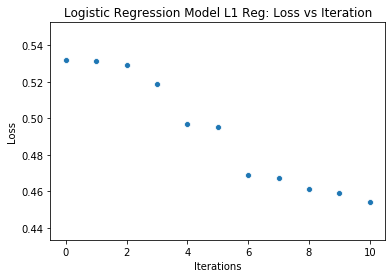

Text(0.5, 1.0, 'Logistic Regression Model L1 Reg: Loss vs Iteration')

In [0]:
# obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory

# plot results per iteration
iterations = np.arange(0, len(objectiveHistory), 1)
sns.scatterplot(x=iterations, y=objectiveHistory)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Logistic Regression Model L1 Reg: Loss vs Iteration')


In [0]:
# keep relevant columns
selectedcols = ["label", "features"] + final_6m_df.columns
dataset = preppedDataDF.select(selectedcols)

In [0]:
# get back the features names from index
feature_index = pd.DataFrame(preppedDataDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+preppedDataDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

In [0]:
# get the coefficients from the model 
coefs = lrModel.coefficients
feature_index['coefs'] = coefs

In [0]:
# average feature coefficients
feature_coef = feature_index.sort_values(by='coefs', ascending=False)
feature_coef['coefs'] = np.abs(feature_coef['coefs'])
feature_coef['feature_names'] = [i.split(',')[0] for i in feature_coef['name']]
feature_coef[['coefs', 'feature_names']].groupby('feature_names').agg('mean').sort_values(by='coefs', ascending=False)


Out[249]: coefs
feature_names 
OP_CARRIER 0.159613
ORIGIN 0.119581
DEST 0.039419
LATE_AIRCRAFT_DELAY 0.022304
TAXI_OUT 0.011021
LONGITUDE 0.006465
DAY_OF_WEEK 0.006424
LATITUDE 0.002745
WND_SPD 0.000502
TMP_TEMP 0.000407
TAXI_IN 0.000357
DEP_TIME 0.000337
WHEELS_OFF 0.000308
MONTH 0.000183
ALTIMETER_SET 0.000176
DEW_TEMP 0.000155
CRS_DEP_TIME 0.000154
CRS_ARR_TIME 0.000135
CRS_ELAPSED_TIME 0.000100
SLP_PRESSURE 0.000030
DISTANCE 0.000024
WHEELS_ON 0.000018
VIS_DIST 0.000014

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 /databricks/python/lib/python3.7/site-packages/IPython/core/formatters.py in __call__ (self, obj) 
 343 method = get_real_method ( obj , self . print_method ) 
 344 if method is not None : 
 --> 345 return method ( ) 
 346 return None 
 347 else : 

 /databricks/python/lib/python3.7/site-packages/pandas/core/frame.py in _repr_html_ (self) 
 732 GH3541 , GH3573
 733 """
 --> 734 width , height = console . get_console_size ( ) 
 735 max_columns = get_option ( "display.max_columns" ) 
 736 nb_columns = len ( self . columns ) 

 /databricks/python/lib/python3.7/site-packages/pandas/io/formats/format.py in to_html (self, buf, encoding, classes, notebook, border) 
 982 Set character encoding . 
 983 classes : str or list - like
 --> 984 classes to include in the ` class ` attribute of the opening
 985 ` ` < table > ` ` tag , in addition to the default "dataframe" . 
 986 notebook : { True , False } , optional , default False 

 /databricks/python/lib/python3.7/site-packages/pandas/io/formats/html.py in __init__ (self, formatter, classes, border, table_id, render_links) 
 54 self.col_space = {
 55 column : f"{value}px" if isinstance ( value , int ) else value
 ---> 56 for column , value in self . fmt . col_space . items ( ) 
 57 }
 58 

 AttributeError : 'NoneType' object has no attribute 'items'

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = lrModel.transform(test)

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.747979698229078

## L2 Regression on L1 feature selection

In [0]:
#final_6m_df.printSchema()
fields_drop = ("WHEELS_OFF" , "CRS_DEP_TIME" , "VIS_DIST" , "SLP_PRESSURE" , "WHEELS_ON" , "CRS_ARR_TIME")
final_6m_1_df = final_6m_df.drop(*fields_drop)

In [0]:
# grab categorical columns
categoricalColumns =  [i[0] for i in final_6m_1_df.dtypes if i[1]=='string']

# stages in pipeline
stages = []

for categoricalCol in categoricalColumns:
  stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
  encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + ",classVec"])
  stages += [stringIndexer, encoder]
  
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="DEP_DEL15", outputCol="label")
stages += [label_stringIdx]



In [0]:
# transform all features into a vector using VectorAssembler
# this basically will have a column called features which stores all the feature values
numericCols = [i[0] for i in final_6m_1_df.drop('DEP_DEL15').dtypes if i[1]!='string']
assemblerInputs = [c + ",classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# puts data through all the feature transformations
partialPipeline2 = Pipeline().setStages(stages)
pipelineModel2 = partialPipeline2.fit(final_6m_1_df)
preppedDataDF2 = pipelineModel2.transform(final_6m_1_df)

In [0]:
# fit model to prepped data (elasticNetParam=1 implies Lasso L2 )
lrModel_l2 = LogisticRegression(maxIter=10, regParam=0.001, elasticNetParam=0).fit(preppedDataDF2)

In [0]:
# extract summary fom model
trainingSummary = lrModel_l2.summary

# obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory

# keep relevant columns
selectedcols = ["label", "features"] + final_6m_1_df.columns
dataset = preppedDataDF2.select(selectedcols)

# get back the features names from index
feature_index = pd.DataFrame(preppedDataDF2.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+preppedDataDF2.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

# get the coefficients from the model 
coefs = lrModel_l2.coefficients
feature_index['coefs'] = coefs

# Evaluation metrics
print("L2 on L1 feature selection dataset")
print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall

print("Accuracy: %s\nFPR: %s\nTPR: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, precision, recall))

# average feature coefficients
feature_coef = feature_index.sort_values(by='coefs', ascending=False)
feature_coef['coefs'] = np.abs(feature_coef['coefs'])
feature_coef['feature_names'] = [i.split(',')[0] for i in feature_coef['name']]
feature_coef[['coefs', 'feature_names']].groupby('feature_names').agg('mean').sort_values(by='coefs', ascending=False)

L2 on L1 feature selection dataset
Precision by label:
label 0: 0.9119871389001172
label 1: 0.9713901529127209
Recall by label:
label 0: 0.9943295166097355
label 1: 0.6673726689251228
Accuracy: 0.9211247397802008
FPR: 0.2594225542453426
TPR: 0.9211247397802007
Precision: 0.9252873172404378
Recall: 0.9211247397802007
Out[207]: coefs
feature_names 
OP_CARRIER 0.367577
DEST 0.344106
CARRIER_DELAY 0.195127
LATE_AIRCRAFT_DELAY 0.190004
ORIGIN 0.117583
MONTH 0.077696
LONGITUDE 0.036076
TAXI_IN 0.029195
DAY_OF_WEEK 0.026165
LATITUDE 0.008252
TAXI_OUT 0.004032
TMP_TEMP 0.003848
WND_SPD 0.003353
DEW_TEMP 0.001967
CRS_ELAPSED_TIME 0.001591
DEP_TIME 0.000865
DISTANCE 0.000167
ALTIMETER_SET 0.000032

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 /databricks/python/lib/python3.7/site-packages/IPython/core/formatters.py in __call__ (self, obj) 
 343 method = get_real_method ( obj , self . print_method ) 
 344 if method is not None : 
 --> 345 return method ( ) 
 346 return None 
 347 else : 

 /databricks/python/lib/python3.7/site-packages/pandas/core/frame.py in _repr_html_ (self) 
 732 GH3541 , GH3573
 733 """
 --> 734 width , height = console . get_console_size ( ) 
 735 max_columns = get_option ( "display.max_columns" ) 
 736 nb_columns = len ( self . columns ) 

 /databricks/python/lib/python3.7/site-packages/pandas/io/formats/format.py in to_html (self, buf, encoding, classes, notebook, border) 
 982 Set character encoding . 
 983 classes : str or list - like
 --> 984 classes to include in the ` class ` attribute of the opening
 985 ` ` < table > ` ` tag , in addition to the default "dataframe" . 
 986 notebook : { True , False } , optional , default False 

 /databricks/python/lib/python3.7/site-packages/pandas/io/formats/html.py in __init__ (self, formatter, classes, border, table_id, render_links) 
 54 self.col_space = {
 55 column : f"{value}px" if isinstance ( value , int ) else value
 ---> 56 for column , value in self . fmt . col_space . items ( ) 
 57 }
 58 

 AttributeError : 'NoneType' object has no attribute 'items'

## L2 Regression to original dataset

In [0]:
# fit model to prepped data (elasticNetParam=1 implies Lasso L1 )
lrModel_l2_1 = LogisticRegression(maxIter=10, regParam=0.001, elasticNetParam=0).fit(preppedDataDF)

In [0]:
# extract summary fom model
trainingSummary = lrModel_l2_1.summary

# obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory

# keep relevant columns
selectedcols = ["label", "features"] + final_6m_1_df.columns
dataset = preppedDataDF.select(selectedcols)

# get back the features names from index
feature_index = pd.DataFrame(preppedDataDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+preppedDataDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

# get the coefficients from the model 
coefs = lrModel_l2_1.coefficients
feature_index['coefs'] = coefs

#Evaluation Metrics
print("L2 on original dataset")
print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall

print("Accuracy: %s\nFPR: %s\nTPR: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, precision, recall))

# average feature coefficients
feature_coef = feature_index.sort_values(by='coefs', ascending=False)
feature_coef['coefs'] = np.abs(feature_coef['coefs'])
feature_coef['feature_names'] = [i.split(',')[0] for i in feature_coef['name']]
feature_coef[['coefs', 'feature_names']].groupby('feature_names').agg('mean').sort_values(by='coefs', ascending=False)

In [0]:
# Remove diverted
#remove possible leakage
# recall 
# precision
#https://spark.apache.org/docs/3.0.1/mllib-evaluation-metrics.html